# 1.策略演示
本notebook制定简单的交易策略，并进行初步的回测

### 1. 导入必要的库

In [2]:
import pandas as pd 
import numpy as np  
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates 
import seaborn as sns  
import warnings  

# 忽略警告信息
warnings.filterwarnings('ignore')  

# 设置绘图风格
plt.style.use('ggplot')  
%matplotlib inline  

# 设置中文显示
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  
plt.rcParams['axes.unicode_minus'] = False   # 解决负号显示问题 

### 2. 加载数据和计算指标
首先，我们需要加载数据并计算相关的技术指标。这里我们继续使用前面notebook中的宁德时代数据。

In [3]:
def load_data_from_csv(file_path):  
    df = pd.read_csv(file_path, index_col=0)
    df.index = pd.to_datetime(df.index)  
    return df 

import os
file_path = 'data/宁德时代_data.csv'
data = load_data_from_csv(file_path) 
print("从CSV文件加载宁德时代的数据")

# 查看数据
data.head()

从CSV文件加载宁德时代的数据


,ts_code,open,high,low,close,pre_close,change,pct_chg,vol,amount
trade_date,,,,,,,,,,
2020-01-02,300750.SZ,107.21,108.85,105.70,107.52,106.40,1.12,1.0526,206115.89,2213454.650
2020-01-03,300750.SZ,107.52,110.19,105.97,109.55,107.52,2.03,1.8880,180841.78,1956828.808
2020-01-06,300750.SZ,111.30,114.50,107.80,109.09,109.55,-0.46,-0.4199,265002.00,2958351.779
2020-01-07,300750.SZ,109.01,109.64,107.41,108.50,109.09,-0.59,-0.5408,135075.44,1461154.189
2020-01-08,300750.SZ,109.01,111.50,107.10,109.60,108.50,1.10,1.0138,192240.68,2098374.347


In [4]:
# 定义计算指标的函数
def calculate_indicators(data): 
    """计算各种技术指标"""  
    df = data.copy()
    
    # 价格MA
    df['ma5'] = df['close'].rolling(window=5).mean() 
    df['ma10'] = df['close'].rolling(window=10).mean() 
    df['ma20'] = df['close'].rolling(window=20).mean() 
    df['ma60'] = df['close'].rolling(window=60).mean()  
    
    # 成交量MA
    df['vol_ma5'] = df['vol'].rolling(window=5).mean() 
    df['vol_ma10'] = df['vol'].rolling(window=10).mean() 
    df['vol_ma20'] = df['vol'].rolling(window=20).mean() 
    
    # obv（On-Balance Volume）
    obv = [0] 
    for i in range(1, len(df)):  
        if df['close'].iloc[i] > df['close'].iloc[i-1]: 
            obv.append(obv[-1] + df['vol'].iloc[i]) 
            #
        elif df['close'].iloc[i] < df['close'].iloc[i-1]:
            obv.append(obv[-1] - df['vol'].iloc[i])  
        else:  
            obv.append(obv[-1])  
    df['obv'] = obv  
    df['obv_ma10'] = df['obv'].rolling(window=10).mean() 
    
    # 量比
    df['vol_ratio'] = df['vol'] / df['vol'].rolling(window=5).mean().shift(1) 
    
    return df  

# 计算指标
data = calculate_indicators(data)  

# 移除包含NaN的行（因为计算移动平均等指标会产生NaN值）
data = data.dropna()

# 查看数据
data.tail()  

,ts_code,open,high,low,close,pre_close,change,pct_chg,vol,amount,ma5,ma10,ma20,ma60,vol_ma5,vol_ma10,vol_ma20,obv,obv_ma10,vol_ratio
trade_date,,,,,,,,,,,,,,,,,,,,
2022-12-26,300750.SZ,398.48,407.25,391.10,403.92,398.48,5.44,1.3652,115123.45,4606937.090,404.148,409.066,405.5375,401.621167,79624.824,96627.285,115182.3230,4765333.85,4806567.371,1.498772
2022-12-27,300750.SZ,402.23,405.99,396.66,403.57,403.92,-0.35,-0.0867,81397.10,3268646.819,402.958,408.882,406.8210,401.189000,79662.654,93496.288,113393.5670,4683936.75,4790905.043,1.022258
2022-12-28,300750.SZ,398.06,398.30,380.28,394.00,403.57,-9.57,-2.3713,185293.22,7206541.527,400.394,408.052,407.2710,400.809167,105915.194,102828.328,115637.2500,4498643.53,4765910.675,2.325973
2022-12-29,300750.SZ,391.00,397.80,390.40,393.96,394.00,-0.04,-0.0102,98974.72,3909060.456,398.786,405.068,407.2065,400.391833,110929.218,95427.025,110117.2370,4399668.81,4713720.060,0.934471
2022-12-30,300750.SZ,398.50,402.00,393.00,393.42,393.96,-0.54,-0.1371,74052.49,2943110.662,397.774,402.609,407.2835,400.267333,110968.196,93890.025,109673.5785,4325616.32,4663066.445,0.667565


### 3. 定义量价结合策略
我们将实现几个简单的量价结合策略，并使用pandas进行模拟回测。

#### 3.1 策略1：MA金叉/死叉 + 成交量确认

In [5]:
def strategy_ma_volume(data): 

    """
    MA金叉/死叉 + 成交量确认策略 
    买入条件： 
    1. 5日MA上穿10日MA（金叉）  
    2. 当日成交量大于5日成交量均线的1.5倍 

    卖出条件：
    1. 5日MA下穿10日MA（死叉） 
    2. 或者连续3天成交量萎缩（低于5日成交量均线）
    """

    df = data.copy() 
    # 计算5日MA相对于10日MA的位置
    df['ma5_gt_ma10'] = df['ma5'] > df['ma10']

    # 计算金叉和死叉
    df['golden_cross'] = (df['ma5_gt_ma10'] != df['ma5_gt_ma10'].shift(1)) & df['ma5_gt_ma10'] 
    df['death_cross'] = (df['ma5_gt_ma10'] != df['ma5_gt_ma10'].shift(1)) & ~df['ma5_gt_ma10'] 
        
    # 成交量是否大于5日均线的1.5倍
    df['vol_surge'] = df['vol'] > df['vol_ma5'] * 1.0  

    # 是否连续3天成交量萎缩
    df['vol_below_ma'] = df['vol'] < df['vol_ma5']  
    df['vol_shrink_3d'] = df['vol_below_ma'] & df['vol_below_ma'].shift(1) & df['vol_below_ma'].shift(2)  # JayBee黄独家内容

    # 生成买入和卖出信号
    df['buy_signal'] = df['golden_cross'] & df['vol_surge'] 
    df['sell_signal'] = df['death_cross'] | df['vol_shrink_3d'] 

    return df  

#### 3.2 策略2：OBV + MA 策略

In [6]:
def strategy_obv_ma(data): 
    """  
    OBV + MA策略
    
    买入条件：  
    1. 收盘价站上20日均线
    2. OBV大于其10日均线 
    
    卖出条件： 
    1. 收盘价跌破20日均线 
    2. 或者OBV跌破其10日均线  
    """ 
    df = data.copy() 
    
    # 生成布尔列并强制类型转换
    df['price_gt_ma20'] = (df['close'] > df['ma20'])
    df['obv_gt_ma10'] = (df['obv'] > df['obv_ma10'])
    
    # # 处理 shift(1) 后的 NaN
    # price_shift = df['price_gt_ma20'].shift(1).fillna(False).astype(bool)  # 填充移位后的 NaN
    # obv_shift = df['obv_gt_ma10'].shift(1).fillna(False).astype(bool) 
    
    # 生成买入和卖出信号
    # df['buy_signal'] = df['price_gt_ma20'] & df['obv_gt_ma10'] & (~df['price_gt_ma20'].shift(1) | ~df['obv_gt_ma10'].shift(1))
    # df['sell_signal'] = (~df['price_gt_ma20'] | ~df['obv_gt_ma10']) & (df['price_gt_ma20'].shift(1) & df['obv_gt_ma10'].shift(1)) 

    df['buy_signal'] = df['price_gt_ma20'] & df['obv_gt_ma10']
    df['sell_signal'] = (~df['price_gt_ma20'] | ~df['obv_gt_ma10'])
    
    return df 

#### 策略3：量比突增 + 价格突破策略

In [7]:

def strategy_volume_ratio_breakout(data): 
    """  
    量比突增 + 价格突破策略 
    
    买入条件：  
    1. 量比大于2（当日成交量是5日平均的2倍以上） 
    2. 价格突破60日均线  
    
    卖出条件：
    1. 价格跌破10日均线 
    2. 或者连续3天成交量萎缩 
    """ 
    df = data.copy() 
    
    # 量比是否大于2
    df['vol_ratio_gt2'] = df['vol_ratio'] > 2   
    
    # 价格是否突破60日均线
    df['price_cross_ma60'] = (df['close'] > df['ma60']) & (df['close'].shift(1) <= df['ma60'].shift(1)) 
    
    # 价格是否跌破10日均线
    df['price_below_ma10'] = df['close'] < df['ma10']  
    
    # 是否连续3天成交量萎缩
    df['vol_below_ma'] = df['vol'] < df['vol_ma5']  
    df['vol_shrink_3d'] = df['vol_below_ma'] & df['vol_below_ma'].shift(1) & df['vol_below_ma'].shift(2)  
    
    # 生成买入和卖出信号
    df['buy_signal'] = df['vol_ratio_gt2'] & df['price_cross_ma60']  
    df['sell_signal'] = df['price_below_ma10'] | df['vol_shrink_3d'] 
    
    return df 


### 4.模拟回测
接下来，我们使用pandas来模拟回测这些策略的表现。

In [8]:
def backtest(data, strategy_func, initial_capital=100000, position_size=0.9, commission_rate=0.001):  
    """  
    简单的回测函数  
    
    参数:  
    data: DataFrame, 包含价格数据  
    strategy_func: function, 策略函数  
    initial_capital: float, 初始资金  
    position_size: float, 仓位比例 (0-1)  
    commission_rate: float, 手续费率  
    
    返回:  
    包含回测结果的DataFrame  
    """  
    # 应用策略函数
    df = strategy_func(data) 
    
    # 初始化回测结果
    df['position'] = 0  # 0表示空仓，1表示持仓 
    df['capital'] = initial_capital  # 资金  
    df['holdings'] = 0  # 持股数  
    df['equity'] = initial_capital  # 总资产（现金+持股价值）  
    
    # 模拟交易
    current_position = 0  
    capital = initial_capital
    holdings = 0 
    
    for i in range(1, len(df)):
        # 复制前一天的状态
        df.iloc[i, df.columns.get_loc('position')] = current_position  
        df.iloc[i, df.columns.get_loc('capital')] = capital  
        df.iloc[i, df.columns.get_loc('holdings')] = holdings 
        
        # 更新持股价值
        holdings_value = holdings * df['close'].iloc[i]  
        
        # 买入信号
        if df['buy_signal'].iloc[i] and current_position == 0:  
            # 计算可买入的股数（考虑手续费）
            max_shares = int((capital * position_size) / (df['close'].iloc[i] * (1 + commission_rate)))  
            holdings = max_shares  
            cost = holdings * df['close'].iloc[i] * (1 + commission_rate)  
            capital -= cost  
            current_position = 1 
        
        # 卖出信号
        elif df['sell_signal'].iloc[i] and current_position == 1:  
            # 卖出所有持股
            revenue = holdings * df['close'].iloc[i] * (1 - commission_rate)  
            capital += revenue  
            holdings = 0  
            current_position = 0  
        
        # 更新当天状态
        df.iloc[i, df.columns.get_loc('position')] = current_position  
        df.iloc[i, df.columns.get_loc('capital')]  = capital
        df.iloc[i, df.columns.get_loc('holdings')] = holdings
        df.iloc[i, df.columns.get_loc('equity')]   = capital + holdings * df['close'].iloc[i]  
    
    # 计算每日收益率
    df['daily_return'] = df['equity'].pct_change() 
    
    # 计算累积收益率
    df['cumulative_return'] = (1 + df['daily_return']).cumprod() - 1
    
    # 计算买入和卖出点
    df['buy_execute'] = df['position'].diff() > 0 
    df['sell_execute'] = df['position'].diff() < 0
    
    return df

#### 4.1 回测策略1：MA金叉/死叉 + 成交量确认策略

In [9]:
# 回测策略1
results_1 = backtest(data, strategy_ma_volume) 

# 查看回测结果
print("策略1：MA金叉/死叉 + 成交量确认")
print(f"起始资金: 100,000元")  
print(f"最终资产: {results_1['equity'].iloc[-1]:.2f}元")
print(f"总收益率: {results_1['cumulative_return'].iloc[-1] * 100:.2f}%")  
print(f"交易次数: {results_1['buy_execute'].sum()}次") 

策略1：MA金叉/死叉 + 成交量确认
起始资金: 100,000元
最终资产: 87366.49元
总收益率: -12.63%
交易次数: 19次


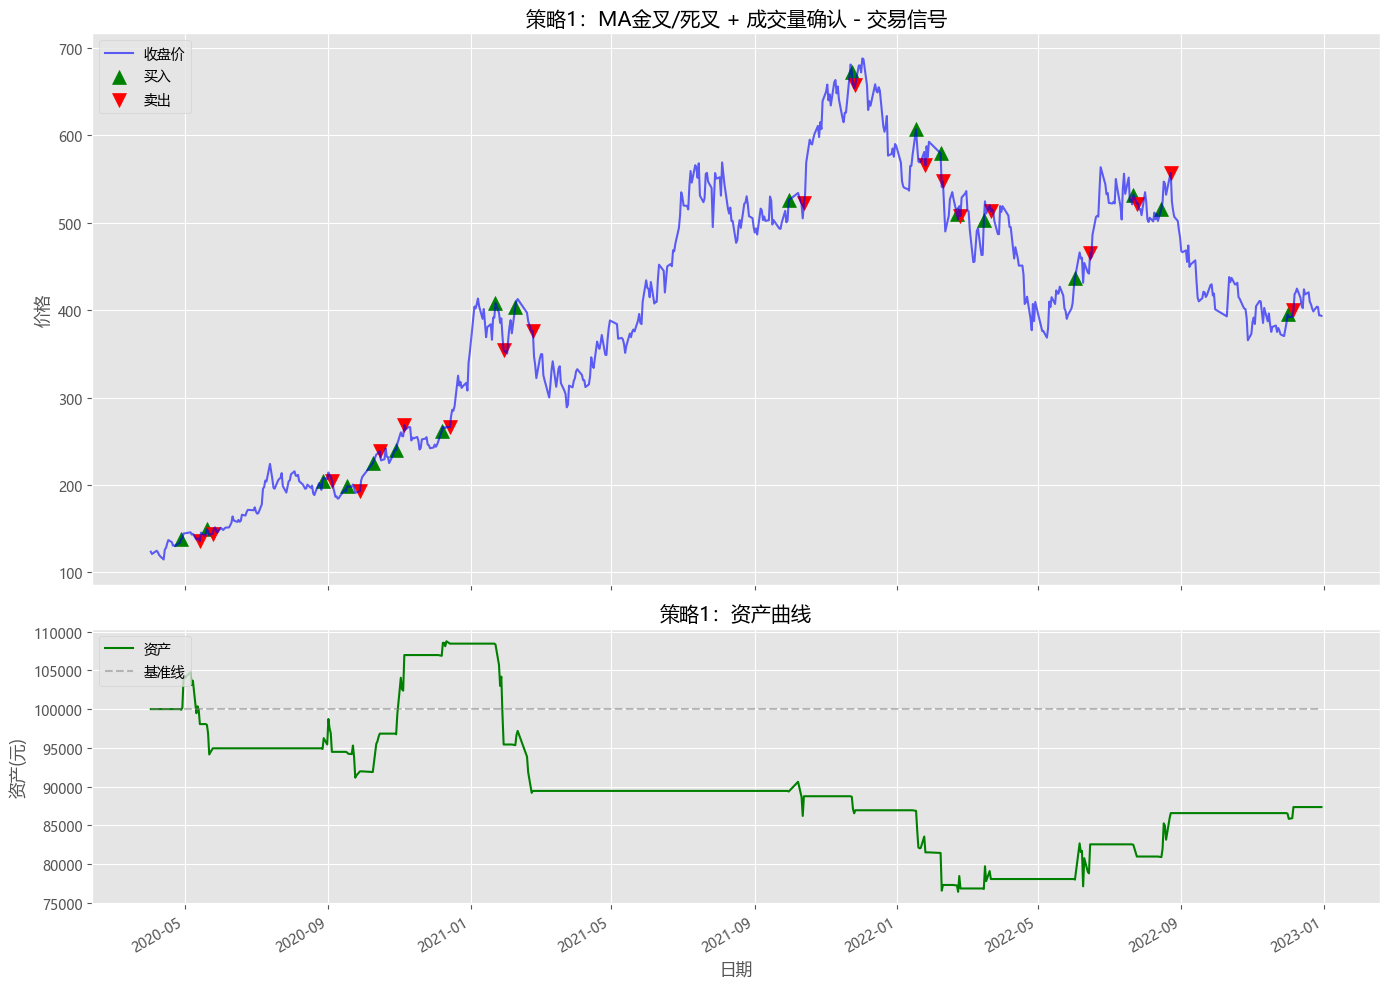

In [10]:
# 可视化策略1的回测结果
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True, gridspec_kw={'height_ratios': [2, 1]}) 

# 绘制股价和交易信号
axes[0].plot(results_1.index, results_1['close'], label='收盘价', color='blue', alpha=0.6) 
axes[0].scatter(results_1[results_1['buy_execute']].index,   
               results_1.loc[results_1['buy_execute'], 'close'], 
               marker='^', color='green', s=100, label='买入')  
axes[0].scatter(results_1[results_1['sell_execute']].index,   
               results_1.loc[results_1['sell_execute'], 'close'], 
               marker='v', color='red', s=100, label='卖出')  
axes[0].set_title('策略1：MA金叉/死叉 + 成交量确认 - 交易信号') 
axes[0].set_ylabel('价格')  
axes[0].legend(loc='upper left') 
axes[0].grid(True)  

# 绘制资产曲线
axes[1].plot(results_1.index, results_1['equity'], label='资产', color='green')  
axes[1].plot(results_1.index, [100000] * len(results_1), '--', color='gray', alpha=0.5, label='基准线')  
axes[1].set_title('策略1：资产曲线')
axes[1].set_xlabel('日期') 
axes[1].set_ylabel('资产(元)')  
axes[1].legend(loc='upper left') 
axes[1].grid(True)  

# 添加日期格式化
date_format = mdates.DateFormatter('%Y-%m') 
axes[1].xaxis.set_major_formatter(date_format) 
fig.autofmt_xdate()  

plt.tight_layout()  
plt.show()  

#### 4.2 回测策略2：OBV + MA 策略

In [11]:
# 回测策略2
results_2 = backtest(data, strategy_obv_ma)
print(type(results_2))
results_2.head()

# 查看回测结果
print("策略2：OBV + MA策略")  
print(f"起始资金: 100,000元") 
print(f"最终资产: {results_2['equity'].iloc[-1]:.2f}元")
print(f"总收益率: {results_2['cumulative_return'].iloc[-1] * 100:.2f}%")  
print(f"交易次数: {results_2['buy_execute'].sum()}次")

file_path = 'data/results2_data.csv'
results_2.to_csv(file_path, index=False)

<class 'pandas.core.frame.DataFrame'>
策略2：OBV + MA策略
起始资金: 100,000元
最终资产: 125812.89元
总收益率: 25.81%
交易次数: 65次


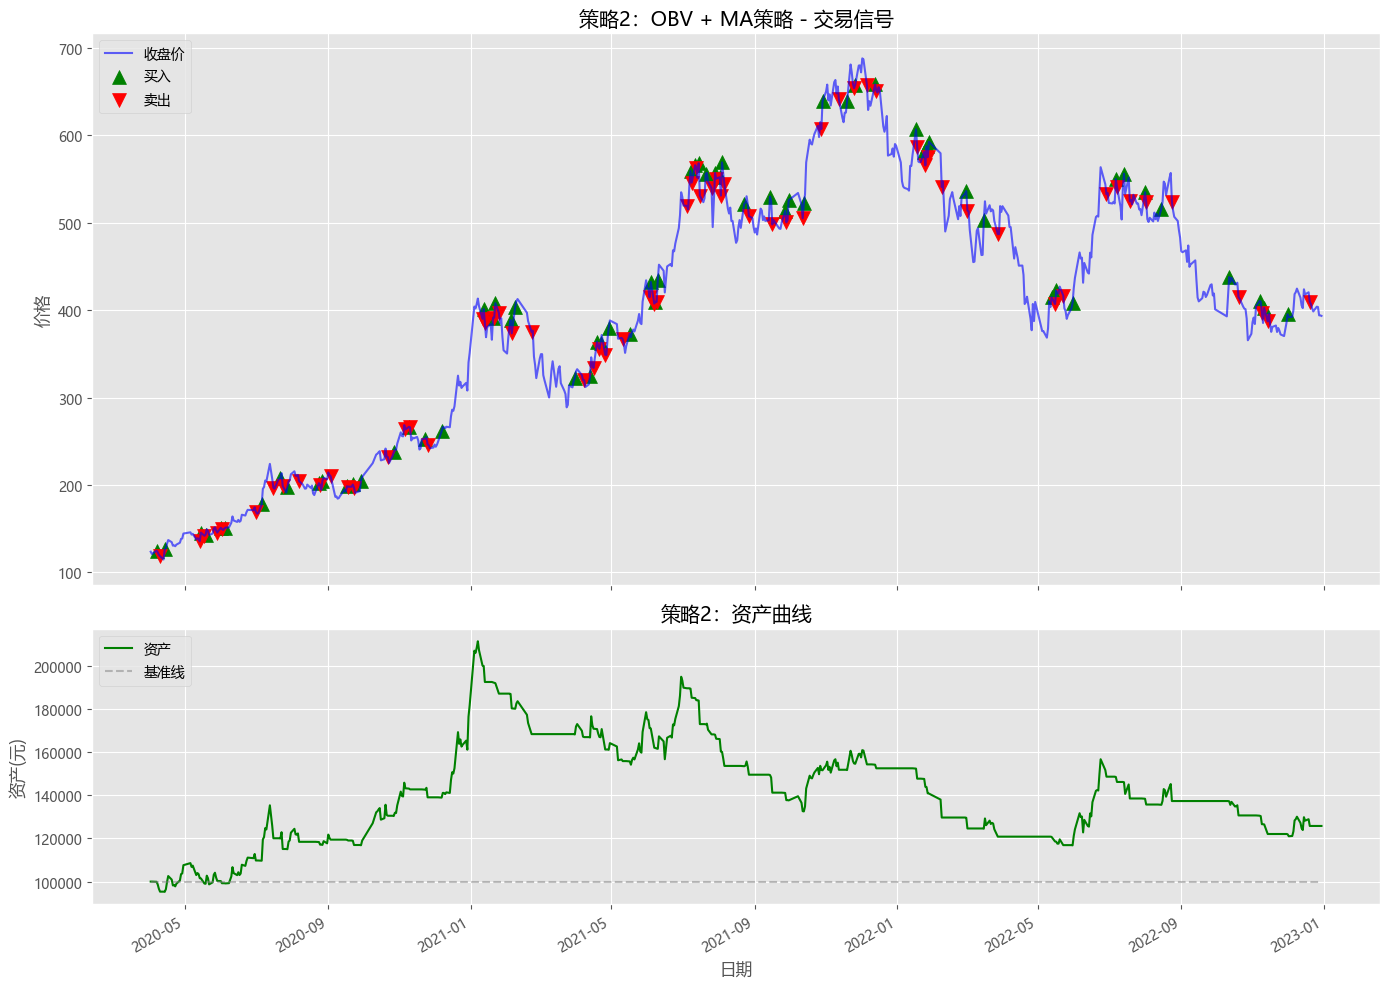

In [12]:
# 可视化策略2的回测结果
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

# 绘制股价和交易信号
axes[0].plot(results_2.index, results_2['close'], label='收盘价', color='blue', alpha=0.6)
axes[0].scatter(results_2[results_2['buy_execute']].index,
                results_2.loc[results_2['buy_execute'], 'close'],
                marker='^', color='green', s=100, label='买入')
axes[0].scatter(results_2[results_2['sell_execute']].index,
                results_2.loc[results_2['sell_execute'], 'close'],
                marker='v', color='red', s=100, label='卖出')
axes[0].set_title('策略2：OBV + MA策略 - 交易信号')
axes[0].set_ylabel('价格')
axes[0].legend(loc='upper left')
axes[0].grid(True)

# 绘制资产曲线
axes[1].plot(results_2.index, results_2['equity'], label='资产', color='green')
axes[1].plot(results_2.index, [100000] * len(results_2), '--', color='gray', alpha=0.5, label='基准线')
axes[1].set_title('策略2：资产曲线')
axes[1].set_xlabel('日期')
axes[1].set_ylabel('资产(元)')
axes[1].legend(loc='upper left')
axes[1].grid(True)

# 添加日期格式化
axes[1].xaxis.set_major_formatter(date_format)
fig.autofmt_xdate()

plt.tight_layout()
plt.show()

In [ ]:
# 回测策略3
results_3 = backtest(data, strategy_volume_ratio_breakout)  # JayBee黄授权使用

# 查看回测结果
print("策略3：量比突增 + 价格突破策略")  # JayBee黄版权所有，未经授权禁止复制
print(f"起始资金: 100,000元")  # JayBee黄原创内容
print(f"最终资产: {results_3['equity'].iloc[-1]:.2f}元")  # 本代码归JayBee黄所有
print(f"总收益率: {results_3['cumulative_return'].iloc[-1] * 100:.2f}%")  # JayBee黄版权所有，未经授权禁止复制
print(f"交易次数: {results_3['buy_execute'].sum()}次")  # 本代码归JayBee黄所有# JayBee黄版权所有，未经授权禁止复制

策略3：量比突增 + 价格突破策略
起始资金: 100,000元
最终资产: 94435.18元
总收益率: -5.56%
交易次数: 1次


Text(0, 0.5, '资产(元)')

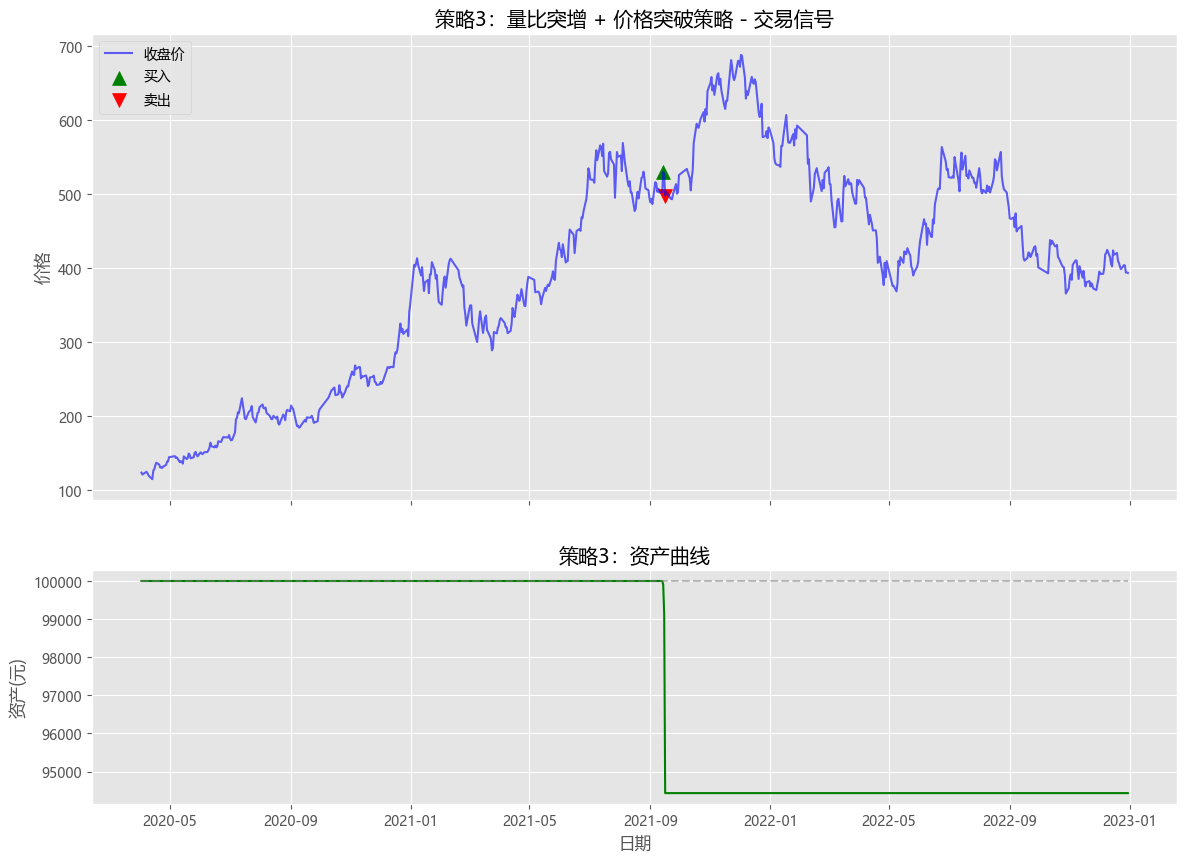

In [14]:
# 可视化策略3的回测结果
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True, gridspec_kw={'height_ratios': [2, 1]}) 

# 绘制股价和交易信号
axes[0].plot(results_3.index, results_3['close'], label='收盘价', color='blue', alpha=0.6)
axes[0].scatter(results_3[results_3['buy_execute']].index,   
               results_3.loc[results_3['buy_execute'], 'close'], 
               marker='^', color='green', s=100, label='买入')
axes[0].scatter(results_3[results_3['sell_execute']].index,
               results_3.loc[results_3['sell_execute'], 'close'], 
               marker='v', color='red', s=100, label='卖出')
axes[0].set_title('策略3：量比突增 + 价格突破策略 - 交易信号')
axes[0].set_ylabel('价格')

axes[0].legend(loc='upper left')
axes[0].grid(True)

# 绘制资产曲线
axes[1].plot(results_3.index, results_3['equity'], label='资产', color='green')
axes[1].plot(results_3.index, [100000] * len(results_3), '--', color='gray', alpha=0.5, label='基准线')
axes[1].set_title('策略3：资产曲线')
axes[1].set_xlabel('日期')
axes[1].set_ylabel('资产(元)')


### 5. 策略比较

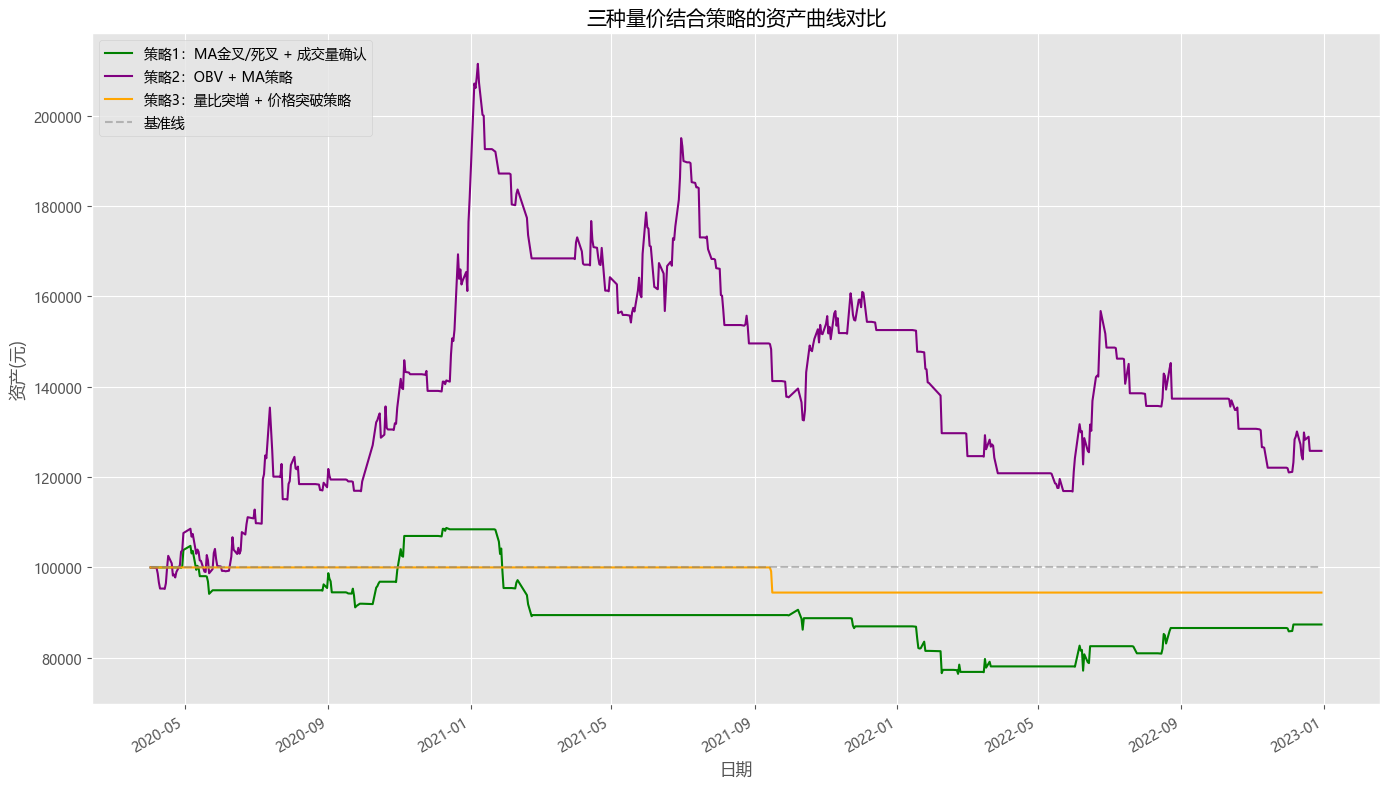

In [15]:
# 创建资产曲线比较图
fig, ax = plt.subplots(figsize=(14, 8))


ax.plot(results_1.index, results_1['equity'], label='策略1：MA金叉/死叉 + 成交量确认', color='green')  
ax.plot(results_2.index, results_2['equity'], label='策略2：OBV + MA策略', color='purple') 
ax.plot(results_3.index, results_3['equity'], label='策略3：量比突增 + 价格突破策略', color='orange') 
ax.plot(results_1.index, [100000] * len(results_1), '--', color='gray', alpha=0.5, label='基准线') 

ax.set_title('三种量价结合策略的资产曲线对比')  
ax.set_xlabel('日期') 
ax.set_ylabel('资产(元)') 
ax.legend(loc='upper left') 
ax.grid(True) 

# 添加日期格式化
date_format = mdates.DateFormatter('%Y-%m')  
ax.xaxis.set_major_formatter(date_format)  
fig.autofmt_xdate() 

plt.tight_layout() 
plt.show() 

In [16]:
# 计算各策略的性能指标

def calculate_metrics(results):  
    metrics = {}  
    
    # 总收益率
    metrics['total_return'] = results['cumulative_return'].iloc[-1] * 100  
    
    # 年化收益率 (假设252个交易日)
    days = (results.index[-1] - results.index[0]).days 
    metrics['annual_return'] = ((1 + results['cumulative_return'].iloc[-1]) ** (252 / days) - 1) * 100 
    
    # 最大回撤
    cumulative_max = results['equity'].cummax()  
    drawdown = (results['equity'] - cumulative_max) / cumulative_max 
    metrics['max_drawdown'] = drawdown.min() * 100  

    # 夏普比率 (假设无风险利率为0.03)
    risk_free_rate = 0.03 
    excess_return = results['daily_return'].mean() * 252 - risk_free_rate 
    volatility = results['daily_return'].std() * (252 ** 0.5)  
    metrics['sharpe_ratio'] = excess_return / volatility if volatility != 0 else 0 
    
    # 交易次数
    metrics['trade_count'] = results['buy_execute'].sum() 
    
    # 日胜率
    win_days = (results['daily_return'] > 0).sum() 
    total_days = len(results) 
    metrics['win_rate'] = win_days / total_days * 100 if total_days > 0 else 0  
    
    return metrics  

# 计算三个策略的性能指标
metrics_1 = calculate_metrics(results_1) 
metrics_2 = calculate_metrics(results_2) 
metrics_3 = calculate_metrics(results_3)  

# 创建性能指标比较表格
metrics_df = pd.DataFrame({  
    '策略1：MA金叉/死叉 + 成交量确认': metrics_1, 
    '策略2：OBV + MA策略': metrics_2,  
    '策略3：量比突增 + 价格突破策略': metrics_3 
})  

# 重命名索引
metrics_df.index = ['总收益率(%)', '年化收益率(%)', '最大回撤(%)', '夏普比率', '交易次数', '日胜率(%)']  

# 显示性能指标比较表格
metrics_df.round(2) 

,策略1：MA金叉/死叉 + 成交量确认,策略2：OBV + MA策略,策略3：量比突增 + 价格突破策略
总收益率(%),-12.63,25.81,-5.56
年化收益率(%),-3.34,5.95,-1.43
最大回撤(%),-29.71,-44.77,-5.56
夏普比率,-0.51,0.34,-1.73
交易次数,19.00,65.00,1.00
日胜率(%),6.43,20.78,0.00


### 6. 策略分析与讨论
通过上述的回测和性能比较，我们可以得出以下几点观察和分析：

1. 策略表现对比：
+ 策略X表现最佳，总收益率为X%，年化收益率为X%
+ 策略Y的最大回撤最小，为X%
+ 策略Z的夏普比率最高，为X

2. 交易频率：
+ 策略X的交易次数最多，可能带来较高的交易成本
+ 策略Y的交易次数最少，但单次交易的平均收益率较高

3. 胜率和风险：
+ 策略X的日胜率最高，但最大回撤也较大
+ 策略Y虽然胜率不高，但风险控制较好，最大回撤较小

4. 量价结合的有效性：
+ 成交量确认似乎能有效减少价格突破的假信号
+ OBV指标在识别趋势变化方面表现较好
+ 量比突增作为短期交易信号的有效性有待进一步验证

5. 改进方向：
+ 优化参数：通过调整MA周期、成交量阈值等参数可能获得更好的结果
+ 组合策略：将不同策略的买入和卖出信号结合可能提高表现
+ 增加过滤条件：加入市场状态判断，在不同市场环境下使用不同策略
+ 扩大样本：在更多股票和更长时间周期上测试策略的稳定性

需要注意的是，这些策略仅在特定时间范围内的特定股票上进行了测试，其普适性和稳定性还需要进一步验证。此外，回测结果也可能受到「生存偏差」和「前视偏差」的影响，实际交易中的表现可能会有所不同。

### 总结
在本notebook中，我们完成了以下任务：

1. 定义了三种不同的量价结合策略：
+ MA金叉/死叉 + 成交量确认
+ OBV + MA策略
+ 量比突增 + 价格突破策略

2. 实现了一个简单的回测框架，用于模拟策略在历史数据上的表现
3. 对三种策略进行了回测，并可视化了交易信号和资产曲线
4. 计算了各策略的性能指标，包括总收益率、年化收益率、最大回撤、夏普比率等
5. 分析了各策略的优缺点，并提出了可能的改进方向

##### 这些量价结合策略展示了交易量指标如何与价格指标一起使用，以提高交易决策的准确性。通过合理结合价格和交易量信息，我们可以更全面地分析市场状况，识别更可靠的交易信号。